In [225]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

In [226]:
df=pd.read_csv("listings.csv")

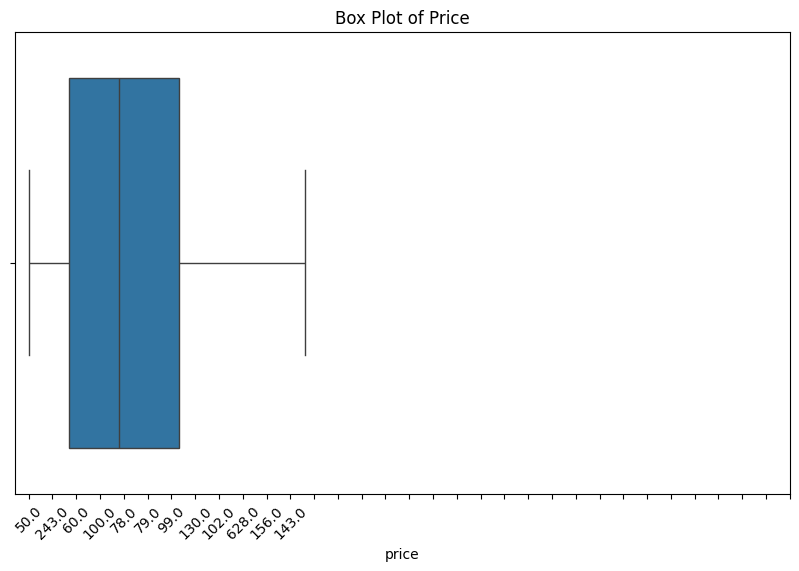

count       325
unique      117
top       100.0
freq         14
Name: price, dtype: object


In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Box Plot of Price')

# 设置坐标轴刻度间隔为每10个值显示一个刻度
plt.xticks(range(0, len(df['price']), 10), rotation=45)
plt.show()

print(df['price'].describe())


In [228]:
df['price'] = df['price'].str.replace('$', '', regex=False)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['price']= df['price'].astype(float)  
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Number of identified outliers:", len(outliers))
df_cleaned = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
df['price']=df['price'].astype(str)

Number of identified outliers: 19
                      id                                       listing_url  \
12              11253948             https://www.airbnb.com/rooms/11253948   
16              13083497             https://www.airbnb.com/rooms/13083497   
18              14989805             https://www.airbnb.com/rooms/14989805   
24              18341426             https://www.airbnb.com/rooms/18341426   
29              20212108             https://www.airbnb.com/rooms/20212108   
40              21449583             https://www.airbnb.com/rooms/21449583   
75              39864828             https://www.airbnb.com/rooms/39864828   
89              43955950             https://www.airbnb.com/rooms/43955950   
163   563711706943869398   https://www.airbnb.com/rooms/563711706943869398   
259   795541666227926706   https://www.airbnb.com/rooms/795541666227926706   
280   831122937768017113   https://www.airbnb.com/rooms/831122937768017113   
284   845960193409947556   htt

In [229]:
#for column in df.columns:
#    print(column)

In [230]:
df=df.dropna(subset=['latitude','longitude','bedrooms','beds','accommodates','availability_365','review_scores_rating','number_of_reviews','property_type','amenities'])


In [232]:
property_dummies = pd.get_dummies(df['property_type'], prefix='type')

# 将新的独热编码的DataFrame附加回原始DataFrame
df = df[df.columns.drop(list(df.filter(regex='type_')))]

# 重新进行独热编码
property_dummies = pd.get_dummies(df['property_type'], prefix='type')

# 将新的独热编码的DataFrame附加回原始DataFrame
df = pd.concat([df, property_dummies], axis=1)

# 打印新的列名，验证是否正确添加
#print([col for col in df.columns if col.startswith('type_')])
#print(df.iloc[:, -20:])

In [233]:
import ast

# 尝试解析字符串形式的列表，如果失败则返回空列表
def parse_list(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# 应用解析函数到每一行的 amenities 列
df['amenities'] = df['amenities'].apply(parse_list)


In [234]:
from sklearn.preprocessing import MultiLabelBinarizer
# 删除所有可能已存在的以 'amenity_' 开头的列（如果之前使用的是不同的前缀，请相应调整）
df = df[df.columns.drop(list(df.filter(regex='amenity_')))]

# 初始化 MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# 对设施列表进行独热编码
amenities_encoded = mlb.fit_transform(df['amenities'])
amenities_df = pd.DataFrame(amenities_encoded, columns=["amenity_" + cls for cls in mlb.classes_])

# 将编码后的DataFrame附加回原始DataFrame
#df = pd.concat([df, amenities_df], axis=1)
# 可以选择删除原始的 amenities 列
#df.drop('amenities', axis=1, inplace=True)


In [235]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 定义原始特征集X和目标变量y
X = df[['latitude', 'longitude', 'bedrooms', 'beds', 'accommodates', 'availability_365', 'review_scores_rating', 'number_of_reviews']]
y = df['price']
y = y.str.replace('$', '', regex=False) 
y = y.astype(float)  

# 添加独热编码列到X
type_columns = [col for col in df.columns if col.startswith('type_')]
X = pd.concat([X, df[type_columns]], axis=1)
#X = pd.concat([X, df[amenities_df]], axis=1)


In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [237]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X.isnull().sum().sum())

0


In [238]:
df=df.dropna(subset=['latitude','longitude','bedrooms','beds','accommodates','availability_365','review_scores_rating','number_of_reviews','property_type'])
#print(df)
#print(X.isnull().sum().sum())

In [239]:
svr_model = SVR(kernel='poly', C=200.0, epsilon=7)

# 在标准化后的训练数据上训练SVR模型
svr_model.fit(X_train_scaled, y_train)

# 使用训练好的模型对标准化后的测试数据进行预测
y_pred = svr_model.predict(X_test_scaled)

# 计算并打印模型的性能指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 966.625466813685
R-squared: 0.6611722435110867


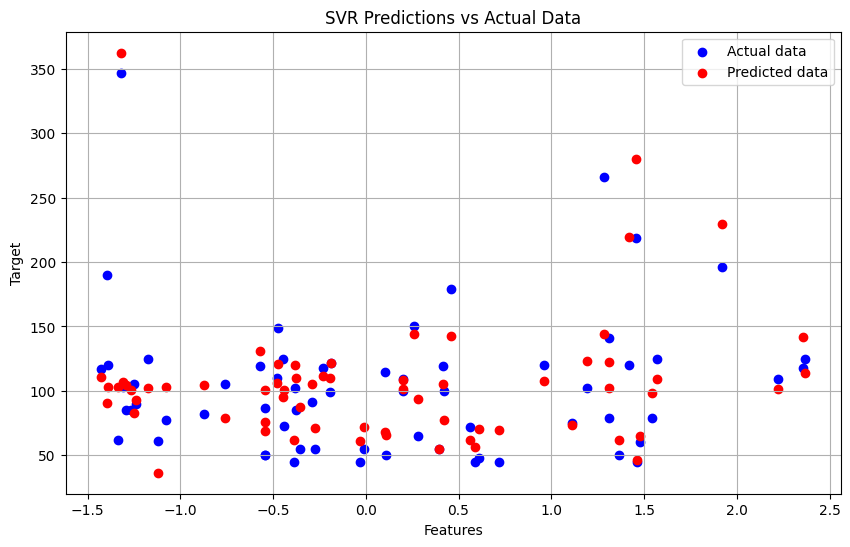

In [240]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[:, 0], y_test, color='blue', label='Actual data')
plt.scatter(X_test_scaled[:, 0], y_pred, color='red', label='Predicted data')
plt.title('SVR Predictions vs Actual Data')
plt.xlabel('Features')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

In [241]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)
print("Explained Variance Score:", explained_variance)


MSE: 966.625466813685
RMSE: 31.09060094005397
MAE: 21.97962291360141
R-squared: 0.6611722435110867
Explained Variance Score: 0.6646885673474803
